# Height profiles averaging

#### started 10/06/21

Here, I am simply picking all the averaged height profiles calculated from individual NPCs and averaging. Trying to see is we can tell something about the regions, within the pores, of higher variability.



In [78]:
%matplotlib inline

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.gridspec as gridspec



In [80]:
# Load the average of all height profiles of NPCs

NPC_Profile=pd.read_csv('/Users/christine/Documents/Data/AFM/Full NPC Databank/2um/2um_crop2/Mean_NPC_2um.txt')
NPC_std=pd.read_csv('/Users/christine/Documents/Data/AFM/Full NPC Databank/2um/2um_crop2/Std_NPC_2um.txt')
#print(NPC_Profile.head())


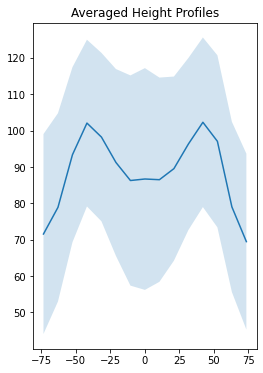

In [81]:
from scipy.signal import argrelmax
from scipy.signal import argrelmin

# creating the x values for the line profiles (nb of bins=15)
x=np.linspace(-73.5, 73.5, 15) 

y = NPC_Profile.iloc[0,slice(5,20)].values
s = NPC_std.iloc[0,slice(5,20)].values

fig, ax0 = plt.subplots(figsize=(4, 6))

ax0.set_title('Averaged Height Profiles')
ax0.plot(x, y)
ax0.fill_between(x, y-s, y+s, alpha=0.2)


-----

I need to play on the offset to align all rings in height.

=> locate the 2 maxima corresponding to the ring

=> calculate the average height between both

=> calculate the offset compared to a reference height of 100nm

=> adjust the profile to correct the offset.



In [82]:
NPCs=pd.read_csv('/Users/christine/Documents/Data/AFM/Full NPC Databank/2um/2um_crop2/NPC_Profiles_2um.txt')
n=len(NPCs)
print(n)

201


In [83]:
# Cropping individual height profiles

NPC_crop = np.empty((n,15))  # creates a matrix with n lines and 15 columns
center=np.empty((n,1))       # creates a column vector with n values
p=np.empty((n,2))              # creates an array to collect the ring coordinates

for i in range(0,n):
    crop = NPCs.iloc[i,slice(5,20)].values
    Max = argrelmax(crop)    # creates an array containing local maxima of the profile (i)
    m = Max[-1]              # recovers the vector with indices of local maxima
    #print(Max, m)
    
    c = m[-1]-m[0]           # calculates the index of NPC center (middle between the 2 extreme local max)
        
    H = (crop[m[0]]+crop[m[-1]])/2
    #print(m[0],m[-1],H)
    
    offset = H-100
    
    # correcting offset
    #print(m)
    crop2 = crop-offset
    NPC_crop [i]= crop2
    center[i] = crop2[c]    # the vector 'center' contains NPC heights at their centers
    #print(crop2)
    p[i] = m[0],m[-1]
    
ring = p.astype(dtype='int')
print(NPC_crop.shape)
print(center.shape)


#print(center)


(201, 15)
(201, 1)


[-73.5 -63.  -52.5 -42.  -31.5 -21.  -10.5   0.   10.5  21.   31.5  42.
  52.5  63.   73.5]
[64.68003731 72.01210614 86.4778607  95.17835821 91.32885572 84.35298507
 79.39029851 79.80597015 79.61343284 82.65522388 89.42860697 95.40124378
 90.17064677 72.13590381 62.58650686]


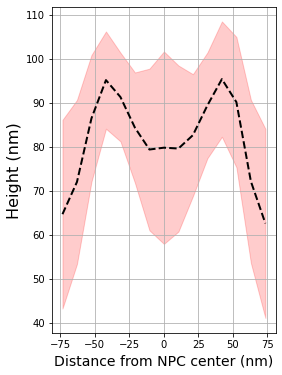

In [84]:
# calculating the mean and std of height profiles

mean = np.mean(NPC_crop, axis=0)
std = np.std(NPC_crop, axis=0)

figure, ax=plt.subplots(figsize=(4,6))
ax.plot(x,mean,color='black', linestyle='--', linewidth=2)
ax.fill_between(x,mean-std, mean+std, alpha=0.2, color='red')
ax.set_xlabel('Distance from NPC center (nm)', fontsize=14)
ax.set_ylabel('Height (nm)', fontsize=16)
ax.grid(True)

plt.savefig('Mean_NPC.tif')
print(x)
print(mean)


**Legend:** The nucleoplasmic height profiles of 200 NPCs were averaged (black line). The shaded area covers the standard deviation along the pore diameter. The central region of pores, where the nuclear basket resides, is highly variable.

-------

Now, I would like to see the distribution of heights at NPC centers, that were already extracted in the vector **"center"**.




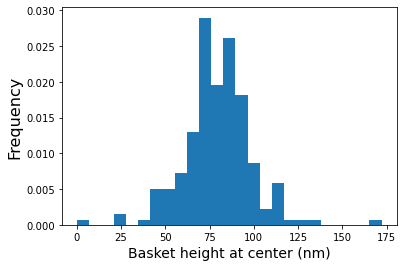

In [85]:

figure, ax1 = plt.subplots(figsize=(6,4))
ax1.hist(center, bins=25, density=True)
ax1.set_xlabel('Basket height at center (nm)', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=16)
plt.show()




----

To spread the variability, I want to integrate the area below the profile curve.
**I have to think about it** (boundaries...)

Ideally, I would even integrate the volume (multiply height by the perimeter at a given radius).
=> if volume is conserved, even when profiles are different, it means that filaments rearrange spatially, but the composition is conserved.

=> if volumes are different (and correlated with profiles), it means that there are variations in the molecular density within the basket **=> does it have to do with Tpr abundance ?** 

This would make a nice transition to introduce correlative microscopy.

***Actually, after discussion with Anthony, he suggested that this will not spread te differences but rather smooth them.
    => I should try the fitting on the height at center.***
    





[1379.15070485   78.67240796   25.91099246]
[910.59226941  80.22962827  12.05480723] [492.50204354  77.94873592  26.0523725 ]
[917.80310774  78.5350072   20.26700037] [296.03713131  86.44258326   5.94642631] [283.94471521  70.84052304   1.83703718]
[268.72817709  70.88504917   1.81173404] [ 14.92261553 114.46450497   0.85730937] [896.158003    77.64156856  19.16551306] [301.00295392  86.74190659   6.12567155]


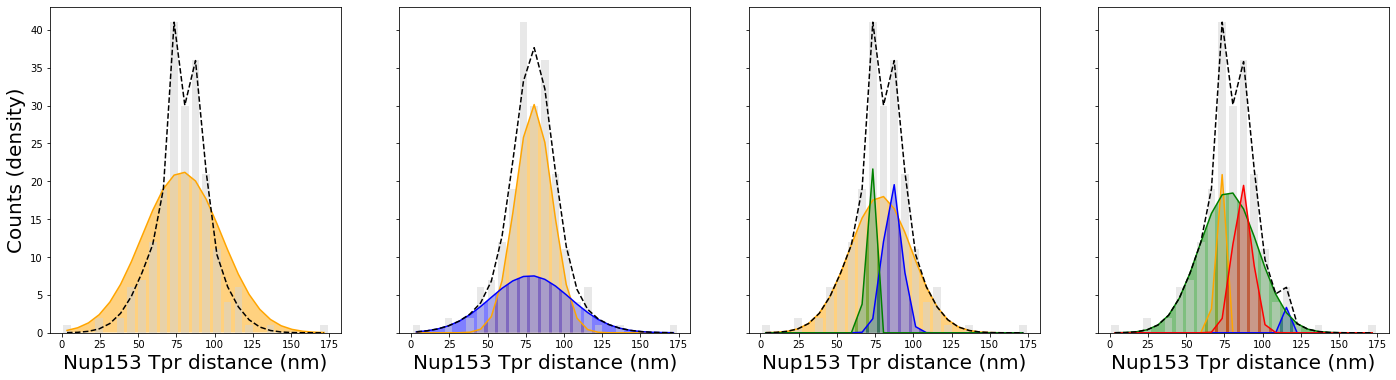

In [88]:
import statistics
import scipy as scipy
from scipy import optimize
from statistics import mean
from matplotlib import gridspec

Hdata, xdata = np.histogram(center, bins=25, range=(0,175))
#print(xdata,ydata)

X = len(xdata)
xcenter = np.empty(X-1)
for j in range (0,X-1):
    xcenter[j] = (xdata[j+1]+xdata[j])/2
    

#print(xcenter.shape, ydata.shape)

# each gaussian is defined by its amplitude, center and sigma


def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

def _3gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2, amp3,cen3,sigma3):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2))) + \
            amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))

def _4gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2, amp3,cen3,sigma3, amp4,cen4,sigma4):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2))) + \
            amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2))) + \
            amp4*(1/(sigma4*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))

# This is the fitting procedure, where p0 are the initial guesses, and bounds the acceptable bounds for each parameter 
# defined in _3gaussian


popt_1gauss, pcov_1gauss = scipy.optimize.curve_fit(_1gaussian, xcenter, ydata,\
                bounds = ((0,0,0),(np.inf, np.inf, 100)))
perr_1gauss = np.sqrt(np.diag(pcov_1gauss))
pars_1 = popt_1gauss[0:3]

popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, xcenter, Hdata, \
                bounds = ((0,0,0,0,0,0),\
                            (np.inf, np.inf, 100,np.inf, np.inf, 100)))
perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
pars_21 = popt_2gauss[0:3]
pars_22 = popt_2gauss[3:6]

popt_3gauss, pcov_3gauss = scipy.optimize.curve_fit(_3gaussian, xcenter, Hdata, \
                bounds = ((0,0,0,0,0,0,0,0,0),\
                            (np.inf, np.inf, 100,np.inf, np.inf, 100,np.inf, np.inf, 100)))
perr_3gauss = np.sqrt(np.diag(pcov_3gauss))
pars_31 = popt_3gauss[0:3]
pars_32 = popt_3gauss[3:6]
pars_33 = popt_3gauss[6:9]

popt_4gauss, pcov_4gauss = scipy.optimize.curve_fit(_4gaussian, xcenter, Hdata, \
                bounds = ((0,0,0,0,0,0,0,0,0,0,0,0),\
                            (np.inf, np.inf, 100,np.inf, np.inf, 100,np.inf, np.inf, 100,np.inf, np.inf, 100)))
perr_4gauss = np.sqrt(np.diag(pcov_4gauss))
pars_41 = popt_4gauss[0:3]
pars_42 = popt_4gauss[3:6]
pars_43 = popt_4gauss[6:9]
pars_44 = popt_4gauss[9:12]

print(pars_1)
print(pars_21, pars_22)
print(pars_31, pars_32, pars_33)
print(pars_41, pars_42, pars_43, pars_44)


# This calaculates the individual gaussians
gauss_peak_1 = _1gaussian(xcenter, *pars_1)

gauss_peak_21 = _1gaussian(xcenter, *pars_21)
gauss_peak_22 = _1gaussian(xcenter, *pars_22)


gauss_peak_31 = _1gaussian(xcenter, *pars_31)
gauss_peak_32 = _1gaussian(xcenter, *pars_32)
gauss_peak_33 = _1gaussian(xcenter, *pars_33)

gauss_peak_41 = _1gaussian(xcenter, *pars_41)
gauss_peak_42 = _1gaussian(xcenter, *pars_42)
gauss_peak_43 = _1gaussian(xcenter, *pars_43)
gauss_peak_44 = _1gaussian(xcenter, *pars_44)


fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(24,6), sharey=True, sharex=True)

ax1.bar(xcenter, Hdata, width=5, align='center', alpha=0.5,color='lightgrey')
ax1.plot(xcenter, gauss_peak_1, "orange")
ax1.fill_between(xcenter, gauss_peak_1.min(), gauss_peak_1, facecolor="orange", alpha=0.5)
ax1.plot(xcenter, _3gaussian(xcenter, *popt_3gauss), 'k--')
ax1.set_xlabel('Nup153 Tpr distance (nm)', fontsize=20)
ax1.set_ylabel('Counts (density)', fontsize=20)


ax2.bar(xcenter, Hdata, width=5, align='center', alpha=0.5, color='lightgrey')
ax2.plot(xcenter, gauss_peak_21, "orange")
ax2.fill_between(xcenter, gauss_peak_21.min(), gauss_peak_21, facecolor="orange", alpha=0.5)
ax2.plot(xcenter, gauss_peak_22, "blue")
ax2.fill_between(xcenter, gauss_peak_22.min(), gauss_peak_22, facecolor="blue", alpha=0.5)
ax2.plot(xcenter, _2gaussian(xcenter, *popt_2gauss), 'k--')
ax2.set_xlabel('Nup153 Tpr distance (nm)', fontsize=20)

ax3.bar(xcenter, Hdata, width=5, align='center', alpha=0.5, color='lightgrey')
ax3.plot(xcenter, gauss_peak_31, "orange")
ax3.fill_between(xcenter, gauss_peak_31.min(), gauss_peak_31, facecolor="orange", alpha=0.5)
ax3.plot(xcenter, gauss_peak_32, "blue")
ax3.fill_between(xcenter, gauss_peak_32.min(), gauss_peak_32, facecolor="blue", alpha=0.5)
ax3.plot(xcenter, gauss_peak_33, "green")
ax3.fill_between(xcenter, gauss_peak_33.min(), gauss_peak_33, facecolor="green", alpha=0.5)
ax3.plot(xcenter, _3gaussian(xcenter, *popt_3gauss), 'k--')
ax3.set_xlabel('Nup153 Tpr distance (nm)', fontsize=20)

ax4.bar(xcenter, Hdata, width=5, align='center', alpha=0.5, color='lightgrey')
ax4.plot(xcenter, gauss_peak_41, "orange")
ax4.fill_between(xcenter, gauss_peak_41.min(), gauss_peak_41, facecolor="orange", alpha=0.5)
ax4.plot(xcenter, gauss_peak_42, "blue")
ax4.fill_between(xcenter, gauss_peak_42.min(), gauss_peak_42, facecolor="blue", alpha=0.5)
ax4.plot(xcenter, gauss_peak_43, "green")
ax4.fill_between(xcenter, gauss_peak_43.min(), gauss_peak_43, facecolor="green", alpha=0.5)
ax4.plot(xcenter, gauss_peak_44, "red")
ax4.fill_between(xcenter, gauss_peak_44.min(), gauss_peak_44, facecolor="red", alpha=0.5)
ax4.plot(xcenter, _4gaussian(xcenter, *popt_4gauss), 'k--')
ax4.set_xlabel('Nup153 Tpr distance (nm)', fontsize=20)

plt.savefig('AFM_center_histoFit_4.tif', format='tiff')
plt.savefig('AFM_center_histoFit_4.jpg')




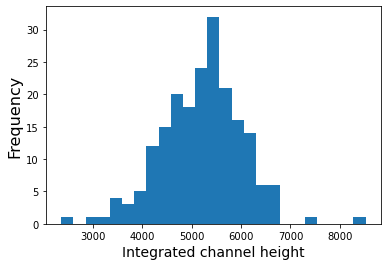

n =  201


In [38]:
from numpy import trapz

area=np.empty((n,1))
x2=np.linspace(-31.5,31.5,7)
dx = 10.5


for i in range (0,n):
    # Compute the area using the composite trapezoidal rule.
    
    y2 = NPC_crop[i,slice(4,11)] 
    
    
    #print(x)
    #print(NPC_crop[i])
    #print(y2)
    a = trapz(y2, x2, axis=0)
    area[i] = a

figure, ax2 = plt.subplots(figsize=(6,4))
ax2.hist(area, bins=25)
ax2.set_xlabel('Integrated channel height', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=16)
plt.show()


print('n = ', n)




Now I would like to fit this histogram with 1, 2 or 3 gaussians.

Then ideally, I would like to recover the identity of pores in each population.

    => does this relate somehow to the morphology (empty / basket) ?



[39404.29200232  5247.78335297   740.3135495 ]


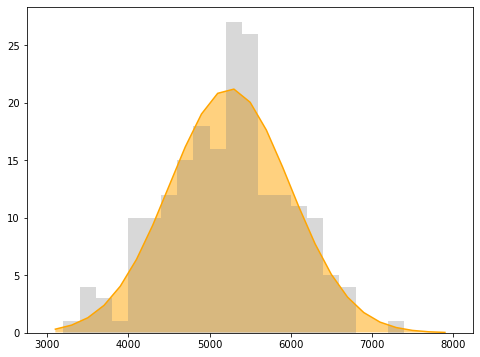

In [77]:
import statistics
import scipy as scipy
from scipy import optimize
from statistics import mean
from matplotlib import gridspec

ydata, xdata = np.histogram(area, bins=25, range=(3000,8000))
#print(xdata,ydata)

X = len(xdata)
xcenter = np.empty(X-1)
for j in range (0,X-1):
    xcenter[j] = (xdata[j+1]+xdata[j])/2
    

#print(xcenter.shape, ydata.shape)

# each gaussian is defined by its amplitude, center and sigma


def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

def _3gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2, amp3,cen3,sigma3):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2))) + \
            amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))

# This is the fitting procedure, where p0 are the initial guesses, and bounds the acceptable bounds for each parameter 
# defined in _3gaussian



popt_1gauss, pcov_1gauss = scipy.optimize.curve_fit(_1gaussian, xcenter, ydata, p0=[25,5500,2000])
                                        
                                        

perr_1gauss = np.sqrt(np.diag(pcov_1gauss))


# The 2 lines below are used for a single Gaussian fitting

#popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, lines[:,0], moyenne[0,:], p0=[10,.2,.1])

#perr_gauss = np.sqrt(np.diag(pcov_gauss))


# pars_n are the recovered parameters from the fit

pars_1 = popt_1gauss[0:3]
#pars_2 = popt_2gauss[3:6]
#pars_3 = popt_3gauss[6:9]

print(pars_1)


# This calaculates the individual gaussians
gauss_peak_1 = _1gaussian(xcenter, *pars_1)
#gauss_peak_2 = _1gaussian(xcenter, *pars_2)
#gauss_peak_3 = _1gaussian(xcenter, *pars_3)



fig, ax1 = plt.subplots(figsize=(8,6))

ax1.bar(xcenter, ydata, width=200, align='center', alpha=0.3, ecolor='lightgrey',color='grey')

ax1.plot(xcenter, gauss_peak_1, "orange")
ax1.fill_between(xcenter, gauss_peak_1.min(), gauss_peak_1, facecolor="orange", alpha=0.5)
  
#ax1.plot(xcenter, gauss_peak_2, "blue")
#ax1.fill_between(xcenter, gauss_peak_2.min(), gauss_peak_2, facecolor="blue", alpha=0.5)  

#ax1.plot(xcenter, gauss_peak_3, "green")
#ax1.fill_between(xcenter, gauss_peak_3.min(), gauss_peak_3, facecolor="green", alpha=0.5)  

#ax1.plot(xcenter, _2gaussian(xcenter, *popt_2gauss), 'k--')




measure distance to mean
